In [30]:
from pyspark.sql import SparkSession

spark = SparkSession.builder .appName("TransportProject") .getOrCreate()
df = spark.read.parquet("/Users/lait-zet/Desktop/Syst-me-Pr-dictif-de-Transport-Urbain/data/Silver/part-00000-06c3f70a-986d-4e1f-9358-9ec2d2161e5e-c000.snappy.parquet")



In [2]:
from pyspark.ml.feature import StringIndexer

indexer = StringIndexer(inputCol="store_and_fwd_flag", outputCol="store_and_fwd_flag_indexed")

indexed_df = indexer.fit(df).transform(df)

indexed_df = indexed_df.drop("store_and_fwd_flag")
indexed_df = indexed_df.drop("tpep_dropoff_datetime")
indexed_df = indexed_df.drop("tpep_pickup_datetime")
indexed_df.show(2)


+--------+---------------+-------------+----------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+------------------+---------------+----------+----------+-----+--------------------------+
|VendorID|passenger_count|trip_distance|RatecodeID|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|Airport_fee|cbd_congestion_fee|duration_minute|pickuphour|dayof_week|month|store_and_fwd_flag_indexed|
+--------+---------------+-------------+----------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+------------------+---------------+----------+----------+-----+--------------------------+
|       1|              1|          1.6|         1|         229|         237|           1|       10.0| 

For the visualization, please refer to the Jupyter Notebook file directly.

Now training the model using the processed data with pyspark and evaluating its performance 

In [3]:
indexed_df

DataFrame[VendorID: int, passenger_count: bigint, trip_distance: double, RatecodeID: bigint, PULocationID: int, DOLocationID: int, payment_type: bigint, fare_amount: double, extra: double, mta_tax: double, tip_amount: double, tolls_amount: double, improvement_surcharge: double, total_amount: double, congestion_surcharge: double, Airport_fee: double, cbd_congestion_fee: double, duration_minute: double, pickuphour: int, dayof_week: int, month: int, store_and_fwd_flag_indexed: double]

In [4]:
selected_columns = ["trip_distance", "passenger_count", "fare_amount", "pickuphour","Airport_fee", "duration_minute"]

new_columns = df.dropna().select(selected_columns)


for col in selected_columns:
    indexed_df.select(col).describe().show()


+-------+------------------+
|summary|     trip_distance|
+-------+------------------+
|  count|           2933233|
|   mean|3.1460329847644495|
| stddev| 4.340674358640314|
|    min|               0.0|
|    max|             199.3|
+-------+------------------+

+-------+------------------+
|summary|   passenger_count|
+-------+------------------+
|  count|           2933233|
|   mean|1.2979674645689585|
| stddev| 0.750772141089596|
|    min|                 0|
|    max|                 9|
+-------+------------------+

+-------+------------------+
|summary|       fare_amount|
+-------+------------------+
|  count|           2933233|
|   mean|17.540811493666872|
| stddev|504.44561148220276|
|    min|            -900.0|
|    max|         863372.12|
+-------+------------------+

+-------+------------------+
|summary|        pickuphour|
+-------+------------------+
|  count|           2933233|
|   mean| 14.37272218061095|
| stddev|5.5402473058150035|
|    min|                 0|
|    max|  

In [5]:
indexed_df = indexed_df.filter((indexed_df.duration_minute >= 0) & (indexed_df.duration_minute <= 240))
indexed_df = indexed_df.filter((indexed_df.fare_amount >= 0) & (indexed_df.fare_amount <= 500))


for col in selected_columns:
    indexed_df.select(col).describe().show()



+-------+-----------------+
|summary|    trip_distance|
+-------+-----------------+
|  count|          2872641|
|   mean|3.134960713851678|
| stddev|4.299122797566852|
|    min|              0.0|
|    max|            199.3|
+-------+-----------------+

+-------+-----------------+
|summary|  passenger_count|
+-------+-----------------+
|  count|          2872641|
|   mean|1.296098607518308|
| stddev|0.749737701971142|
|    min|                0|
|    max|                9|
+-------+-----------------+

+-------+------------------+
|summary|       fare_amount|
+-------+------------------+
|  count|           2872641|
|   mean|18.033455245540058|
| stddev| 17.32599342772178|
|    min|               0.0|
|    max|             500.0|
+-------+------------------+

+-------+-----------------+
|summary|       pickuphour|
+-------+-----------------+
|  count|          2872641|
|   mean|14.37228703482266|
| stddev|5.532026897556199|
|    min|                0|
|    max|               23|
+-------

In [6]:
indexed_df.count()

2872641

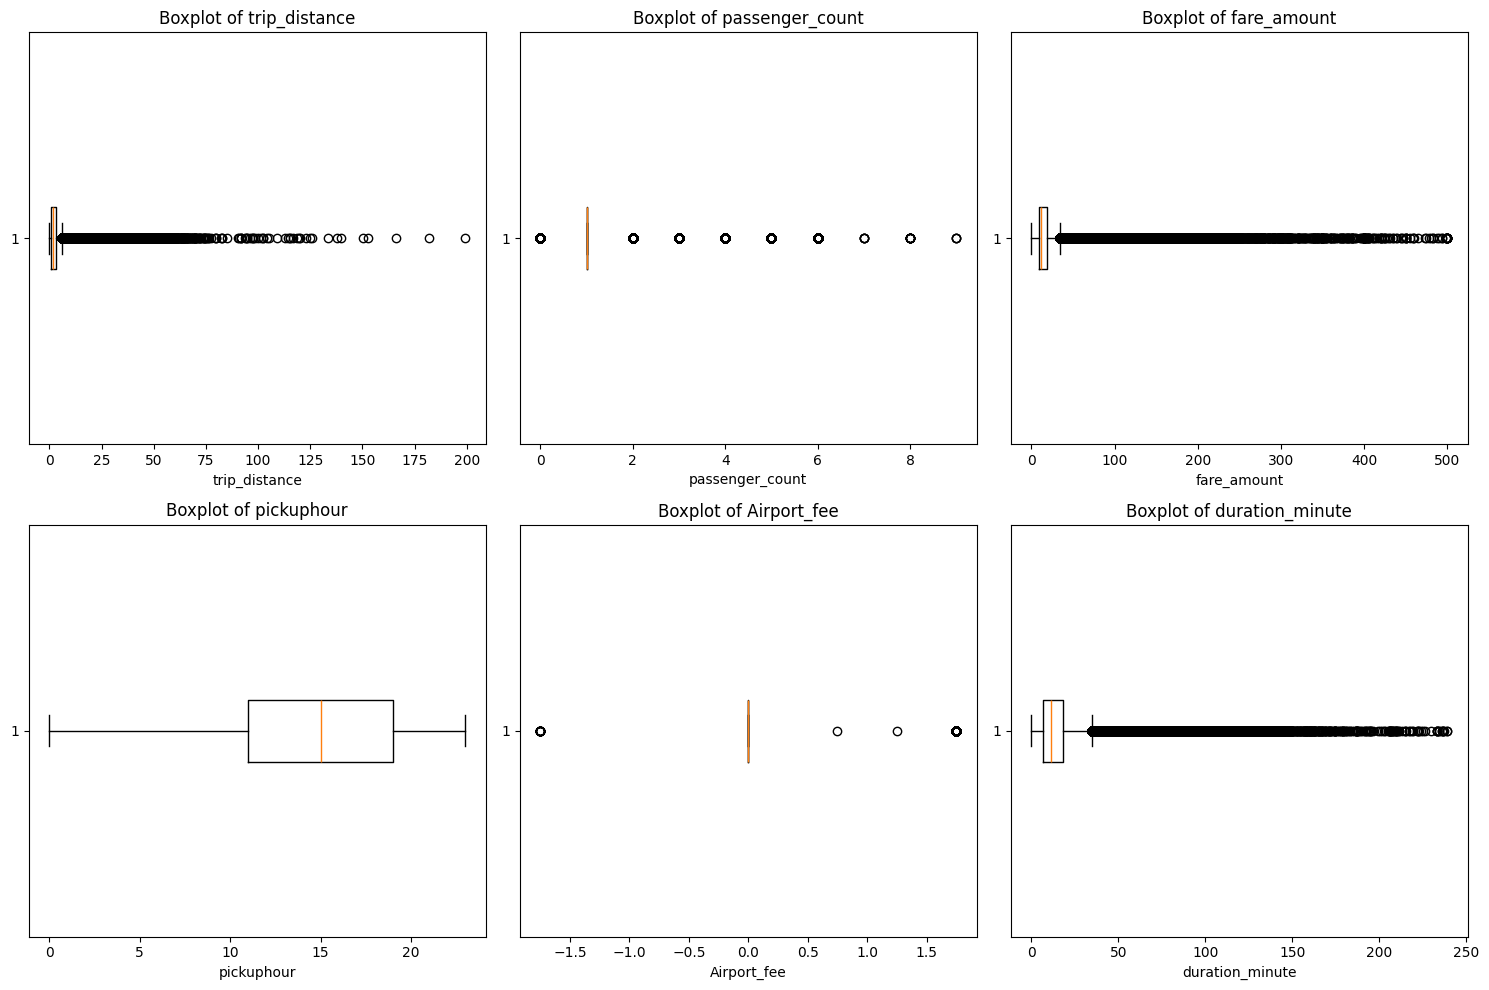

In [7]:
import matplotlib.pyplot as plt
import pandas as pd

pandas_df = indexed_df.select(selected_columns).toPandas()

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))

for i, col in enumerate(selected_columns):
    axes.flat[i].boxplot(pandas_df[col], vert=False)
    axes.flat[i].set_title(f'Boxplot of {col}')
    axes.flat[i].set_xlabel(col)

plt.tight_layout()
plt.show()

In [8]:
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator

In [ ]:
def prepare_data(df, feature_cols, label_col):
    assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
    assembled_df = assembler.transform(df)
    final_df = assembled_df.select("features", label_col)
    return final_df
feature_columns = ["trip_distance", "passenger_count", "pickuphour", "Airport_fee", "fare_amount"]
label_column = "duration_minute"
final_df = prepare_data(indexed_df, feature_columns, label_column)


+--------------------+---------------+
|            features|duration_minute|
+--------------------+---------------+
|[1.6,1.0,0.0,0.0,...|           8.35|
|[0.5,1.0,0.0,0.0,...|           2.55|
+--------------------+---------------+
only showing top 2 rows


In [23]:
def Generate_scaled_data(final_df):
    scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures", withStd=True, withMean=False)
    scaler_model = scaler.fit(final_df)
    scaled_data = scaler_model.transform(final_df)
    return scaled_data

scaled_data = Generate_scaled_data(final_df)

In [24]:
def train_test_split(scaled_data, train_ratio=0.8):
    train_data, test_data = scaled_data.randomSplit([train_ratio, 1 - train_ratio], seed=42)
    return train_data, test_data

train_data, test_data = train_test_split(scaled_data)

In [25]:
def train_random_forest(train_data, label_col):
    rf = RandomForestRegressor(featuresCol="scaledFeatures", labelCol=label_col, numTrees=100, maxDepth=10, seed=42)
    rf_model = rf.fit(train_data)
    return rf_model

def evaluate_model(rf_model, test_data, label_col):
    predictions = rf_model.transform(test_data)
    evaluator = RegressionEvaluator(labelCol=label_col, predictionCol="prediction", metricName="r2")
    r2 = evaluator.evaluate(predictions)
    return r2

rf_model = train_random_forest(train_data, label_column)
r2 = evaluate_model(rf_model, test_data, label_column)
print({r2})


26/01/09 11:53:29 WARN MemoryStore: Not enough space to cache rdd_327_5 in memory! (computed 108.7 MiB so far)
26/01/09 11:53:29 WARN BlockManager: Persisting block rdd_327_5 to disk instead.
26/01/09 11:53:40 WARN MemoryStore: Not enough space to cache rdd_327_5 in memory! (computed 368.0 MiB so far)
26/01/09 11:53:48 WARN MemoryStore: Not enough space to cache rdd_327_5 in memory! (computed 368.0 MiB so far)
26/01/09 11:54:00 WARN MemoryStore: Not enough space to cache rdd_327_5 in memory! (computed 368.0 MiB so far)
26/01/09 11:54:15 WARN MemoryStore: Not enough space to cache rdd_327_5 in memory! (computed 368.0 MiB so far)
26/01/09 11:54:36 WARN MemoryStore: Not enough space to cache rdd_327_5 in memory! (computed 368.0 MiB so far)
26/01/09 11:55:03 WARN DAGScheduler: Broadcasting large task binary with size 1031.3 KiB
26/01/09 11:55:03 WARN MemoryStore: Not enough space to cache rdd_327_5 in memory! (computed 368.0 MiB so far)
26/01/09 11:55:33 WARN DAGScheduler: Broadcasting lar

[1307.738s][warning][gc,alloc] Executor task launch worker for task 3.0 in stage 157.0 (TID 929): Retried waiting for GCLocker too often allocating 1282 words


26/01/09 11:57:22 WARN MemoryStore: Not enough space to cache rdd_327_5 in memory! (computed 368.0 MiB so far)
26/01/09 11:58:02 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB


{0.8350488828195}


Saved model 

In [36]:
assembler = VectorAssembler(
    inputCols=feature_columns,
    outputCol="features"
)

scaler = StandardScaler(
    inputCol="features",
    outputCol="scaledFeatures",
    withStd=True,
    withMean=False
)

rf_model.write().overwrite().save("Models/random_forest_model")
scaler_model = scaler.fit(final_df)
scaler_model.write().overwrite().save("Models/scaler_model")


26/01/09 14:55:43 WARN TaskSetManager: Stage 206 contains a task of very large size (2468 KiB). The maximum recommended task size is 1000 KiB.


In [41]:
from pyspark.ml.regression import RandomForestRegressionModel
from pyspark.ml.feature import StandardScalerModel

rf_model = RandomForestRegressionModel.load("Models/random_forest_model")
scaler_model = StandardScalerModel.load("Models/scaler_model")

new_data = spark.createDataFrame(
    [(2.0, 4, 14, 8.0, 30.0)],
    feature_columns
)

assembler = VectorAssembler(
    inputCols=feature_columns,
    outputCol="features"
)

new_data_assembled = assembler.transform(new_data)
new_data_scaled = scaler_model.transform(new_data_assembled)

predictions = rf_model.transform(new_data_scaled)
predictions.select("prediction").show()


+------------------+
|        prediction|
+------------------+
|14.797508167555383|
+------------------+



Loading the saved model and using it for predictions